In [253]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats
from provided.utils import JacobiGQ, JacobiGL

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi
from math import gamma as gamma_function
from math import factorial

## 2h) - Pernille

In [64]:
def aHelper(alpha, beta, n1, n2):
    if n1 == -1 and n2 == 0:
        return 0
    
    elif n1 == n2 - 1 and n2 > 0:
        return 2 * (n2 + alpha) * (n2 + beta) / ((2*n2 + alpha + beta + 1) * (2*n2 + alpha + beta))
    
    elif n1 == n2:
        return (alpha**2 - beta**2) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta))
    
    elif n1 == n2 + 1:
        return 2 * n1 * (n1 + alpha + beta) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta + 1))
    
    else:
        raise ValueError("Invalid n1, n2 combination in aHelper")

def JacobiP(x, alpha, beta, n):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 1/2 * (alpha - beta + x * (alpha + beta + 2))
    else:
        return ((aHelper(alpha, beta, n-1, n-1) + x) * JacobiP(x, alpha, beta, n-1) 
                - aHelper(alpha, beta, n-2, n-1) * JacobiP(x, alpha, beta, n-2)) / aHelper(alpha, beta, n, n-1)

## 2i) - decay in coef

In [ ]:
alpha, beta = 0, 0
N = 300

x, w = JacobiGQ(alpha, beta, N)
print(x.shape, w.shape)

x_scipy, w_scipy = roots_jacobi(n=(N+1), alpha=alpha, beta=beta)
print(x_scipy.shape, w_scipy.shape)

print(np.linalg.norm(x - x_scipy))
print(np.linalg.norm(w - w_scipy))

# k_test = 15
# x_jacobi_own = JacobiP(x = x, alpha = alpha, beta = beta, n = k_test)
# x_jacobi_scipy = legendre(k_test)(x)
# print(np.linalg.norm(x_jacobi_own - x_jacobi_scipy))

# def gamma_exact(n, alpha=alpha, beta=beta):
#     return (2**(alpha+beta+1) * gamma_function(n+alpha+1) * gamma_function(n+beta+1)) /\
#         (factorial(n) * (2*n + alpha + beta + 1) * gamma_function(n+alpha+beta+1))

# print(gamma_exact(n = 100, alpha = alpha, beta = beta))
# print(gamma_exact(n = 98, alpha = alpha, beta = beta))
# print(gamma_exact(n = 97, alpha = alpha, beta = beta))

(101,) (101,)
(101,) (101,)
9.321993565347081e-16
1.4172663903490913e-14


In [208]:
def u(x): return 1.0 / (2.0 - np.cos(np.pi*(x + 1))) # function defined on [-1, 1]

alpha, beta = 0, 0
K_max = 200
N_grid = np.array([10, 40, 80, 100, 200])
# N_grid = np.array([10])

coeficients = np.zeros((len(N_grid), K_max))

def compute_coef(u_function, alpha, beta, N, K_max):
    x = JacobiGL(alpha, beta, N)
    w = 2 / (N * (N+1)) / np.power(legendre(N)(x), 2)
    u_x = u_function(x)
    Phi = np.column_stack([eval_jacobi(k, alpha, beta, x) for k in range(K_max)]).T # shape (K_max, N+1)
    gamma = (Phi ** 2) @ w # shape (K_max, )
    f_tilde = Phi @ (u_x * w) / gamma # shape (K_max, )
    return f_tilde

for i, N in enumerate(N_grid):
    coeficients[i, :] = compute_coef(u_function = u, alpha=alpha, beta=beta, N=N, K_max=K_max)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: divide by zero encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: overflow encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: invalid value encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarning: divide by zero encountered in matmul
  f_tilde = Phi @ (u_x * w) / gamma # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarning: overflow encountered in matmul
  f_tilde = Phi @ (u_x * w) / gamma # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarnin

In [209]:
x_plot = np.linspace(-1, 1, 500)
u_x_array = u(x_plot)

K_max = 200
u_x_approx_array = np.zeros((len(N_grid), len(x_plot)))
u_x_approx_array_clipped = np.zeros((len(N_grid), len(x_plot)))

N_clip_grid = np.array([200, 25, 100, 150, 200])

for i, N in enumerate(N_grid):

    f_tilde = compute_coef(u_function = u, alpha=alpha, beta=beta, N=N, K_max=K_max)
    Phi = np.column_stack([eval_jacobi(k, alpha, beta, x_plot) for k in range(K_max)])
    # u_x_approx = Phi @ f_tilde
    u_x_approx = Phi * f_tilde
    
    u_x_approx_array[i, :] = np.sum(u_x_approx, axis = 1)
    u_x_approx_array_clipped[i, :] = np.sum(u_x_approx[:, :N_clip_grid[i]], axis=1)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: divide by zero encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: overflow encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: invalid value encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarning: divide by zero encountered in matmul
  f_tilde = Phi @ (u_x * w) / gamma # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarning: overflow encountered in matmul
  f_tilde = Phi @ (u_x * w) / gamma # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:16: RuntimeWarnin

Text(0.5, 0, 'k')

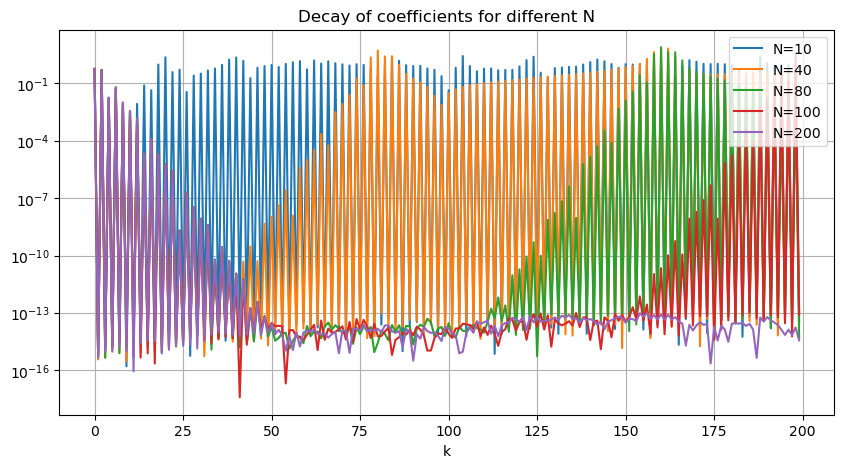

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, N in enumerate(N_grid):
    ax.semilogy(np.abs(coeficients[i, :]), label=f'N={N}')
ax.grid()
ax.legend(loc = "upper right")
ax.set_title('Decay of coefficients for different N')
ax.set_xlabel('k')

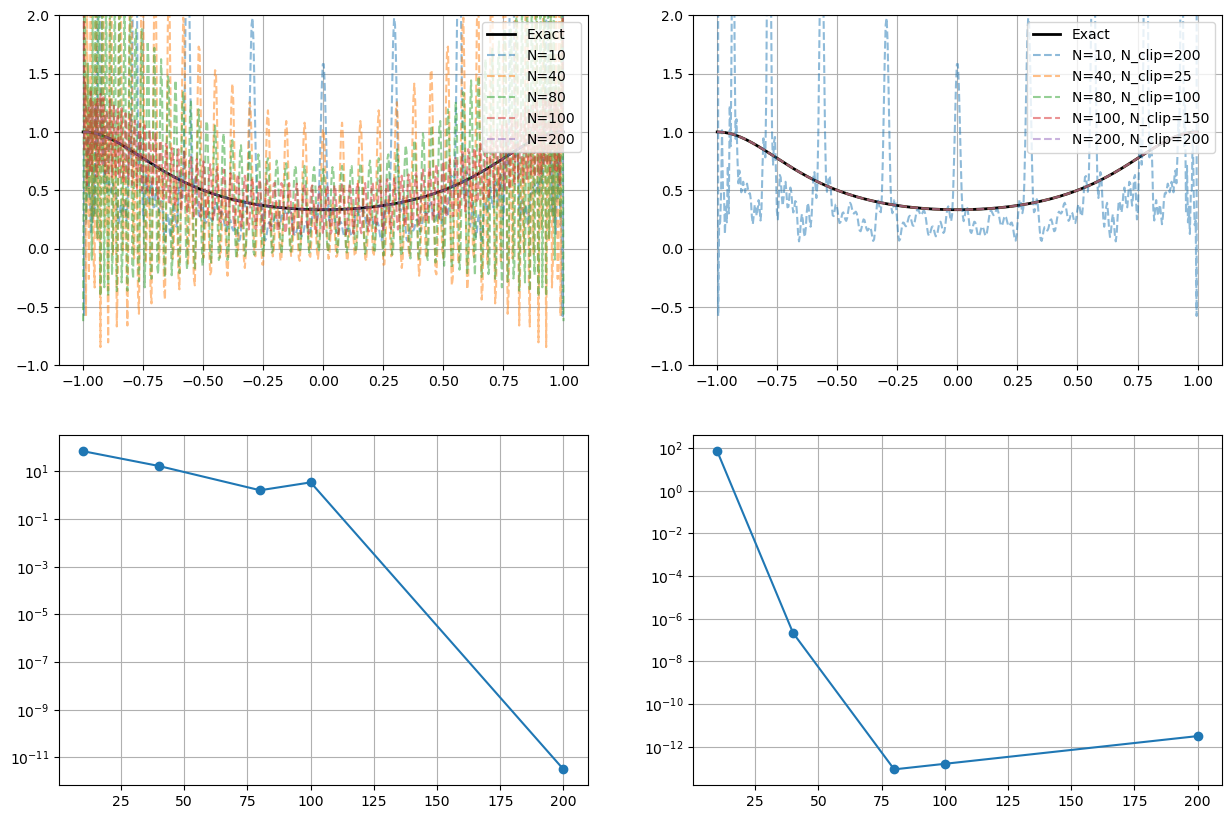

In [211]:
error_u_x_approx = np.linalg.norm(u_x_array - u_x_approx_array, ord = np.inf, axis = 1)
error_u_x_approx_clipped = np.linalg.norm(u_x_array - u_x_approx_array_clipped, ord = np.inf, axis = 1)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(x_plot, u_x_array, 'k-', label='Exact', linewidth=2)
for i, N in enumerate(N_grid):
    ax[0, 0].plot(x_plot, u_x_approx_array[i, :], label=f'N={N}', alpha=0.5, linestyle = "--")
ax[0, 0].grid()
ax[0, 0].legend(loc = "upper right")
ax[0, 0].set_ylim([-1, 2])

ax[0, 1].plot(x_plot, u_x_array, 'k-', label='Exact', linewidth=2)
for i, N in enumerate(N_grid):
    ax[0, 1].plot(x_plot, u_x_approx_array_clipped[i, :], label=f'N={N}, N_clip={N_clip_grid[i]}', alpha=0.5, linestyle = "--")
ax[0, 1].grid()
ax[0, 1].legend(loc = "upper right")
ax[0, 1].set_ylim([-1, 2])

ax[1, 0].semilogy(N_grid, error_u_x_approx, marker = "o")
ax[1, 0].grid();

ax[1, 1].semilogy(N_grid, error_u_x_approx_clipped, marker = "o")
ax[1, 1].grid();

## 2j) - Vandermonde matrix

In [212]:
def constructV(x, alpha=0, beta=0):
    N = x.shape[0]
    V = np.zeros((N, N))
    for n in range(N):
        V[n, :] = eval_jacobi(n, alpha, beta, x)
    return V.T

(7, 7)
(7, 100)
(7, 100)


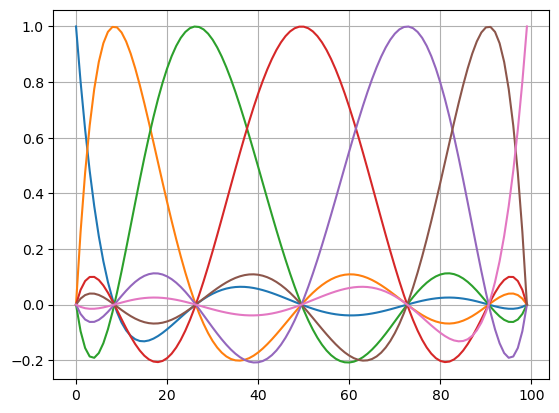

In [214]:
N = 6
x = JacobiGL(alpha, beta, N)

V = constructV(x, alpha=alpha, beta=beta)
print(V.shape)

x_plot = np.linspace(-1, 1, 100)

def evaluate_jacobi_grid(x_eval, x_nodes, alpha=0, beta=0):
    N = x_nodes.shape[0]
    M = x_eval.shape[0]
    A = np.zeros((N, M))
    for n in range(N):
        A[n, :] = eval_jacobi(n, alpha, beta, x_eval)
    return A

A = evaluate_jacobi_grid(x_plot, x, alpha=alpha, beta=beta)
print(A.shape)

h_lagrange = linalg.solve(V.T, A)
print(h_lagrange.shape)

plt.plot(h_lagrange.T);
plt.grid();

In [ ]:
# Note: Vandermode matrix is not used

def v(x): return np.sin(np.pi * x)

N_grid = np.arange(1, 50, step = 5)

v_x_approx_array = np.zeros((len(N_grid), len(x_plot)))

for i, N in enumerate(N_grid):
    v_tilde = compute_coef(u_function = v, alpha=alpha, beta=beta, N=N, K_max=N)
    Phi = np.column_stack([eval_jacobi(k, alpha, beta, x_plot) for k in range(N)])
    v_x_approx = Phi @ v_tilde
    v_x_approx_array[i, :] = v_x_approx

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/436840040.py:10: RuntimeWarning: divide by zero encountered in matmul
  v_x_approx = Phi @ v_tilde
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/436840040.py:10: RuntimeWarning: overflow encountered in matmul
  v_x_approx = Phi @ v_tilde
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/436840040.py:10: RuntimeWarning: invalid value encountered in matmul
  v_x_approx = Phi @ v_tilde
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: divide by zero encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: overflow encountered in matmul
  gamma = (Phi ** 2) @ w # shape (K_max, )
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/1888162550.py:15: RuntimeWarning: invalid value encountered in matmul
  gamma = (Phi ** 2) @ w # s

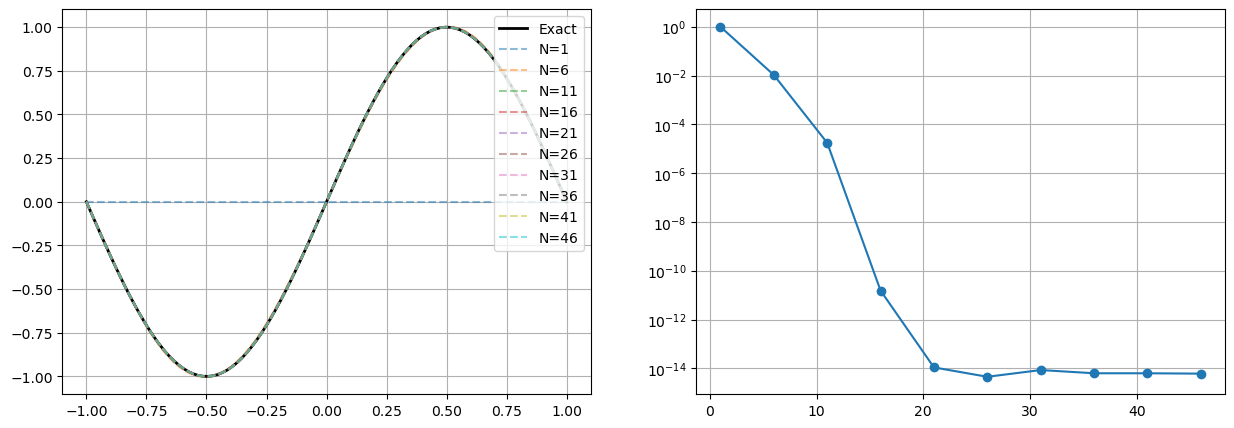

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(x_plot, v(x_plot), 'k-', label='Exact', linewidth=2)
for i, N in enumerate(N_grid):
    ax[0].plot(x_plot, v_x_approx_array[i, :], label=f'N={N}', alpha=0.5, linestyle = "--")
ax[0].grid()
ax[0].legend(loc = "upper right")

error_v_x_approx = np.linalg.norm(v(x_plot) - v_x_approx_array, ord = np.inf, axis = 1)
ax[1].semilogy(N_grid, error_v_x_approx, marker = "o")
ax[1].grid();
plt.show()

## 2k) - GradJacobiP

In [245]:
def constructVx(x, alpha=0, beta=0):
    "Function for constructing the derivative of Vandermonde matrix, Vx = dV/dx"
    N = x.shape[0]
    Vx = np.zeros((N, N))
    for n in range(1, N):
        Vx[n, :] = ((n + alpha + beta + 1)/2) * eval_jacobi(n-1, alpha+1, beta+1, x)
    return Vx.T

In [ ]:
N = 10
alpha, beta = 0, 0

def v(x): return np.exp(np.sin(np.pi*(x + 1)))
def dv(x): return np.exp(np.sin(np.pi*(x + 1))) * np.pi * np.cos(np.pi*(x + 1))

N_grid = np.logspace(1, 2, num = 30, dtype = int)
error_dv_array = np.zeros((len(N_grid)))
error_l2_norm = np.zeros((len(N_grid)))

for i, N in enumerate(N_grid):

    x = JacobiGL(alpha, beta, N)
    V = constructV(x, alpha=alpha, beta=beta)
    Vx = constructVx(x, alpha=alpha, beta=beta)
    # solve D = Vx V^{-1} <=> D V = Vx <=> V.T D.T = Vx.T <=> D.T = solve(V.T, Vx.T) <=> D = solve(V.T, Vx.T).T
    D = linalg.solve(V.T, Vx.T).T
    v_x = v(x)
    dv_approx = D @ v_x

    error = dv(x) - dv_approx
    error_dv_array[i] = np.linalg.norm(error, ord = np.inf)
    error_l2_norm[i] = np.sqrt(error.T @ np.linalg.inv(V @ V.T) @ error)

/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.py:23: RuntimeWarning: divide by zero encountered in matmul
  error_l2_norm[i] = np.sqrt(error.T @ np.linalg.inv(V @ V.T) @ error)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.py:23: RuntimeWarning: overflow encountered in matmul
  error_l2_norm[i] = np.sqrt(error.T @ np.linalg.inv(V @ V.T) @ error)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.py:23: RuntimeWarning: invalid value encountered in matmul
  error_l2_norm[i] = np.sqrt(error.T @ np.linalg.inv(V @ V.T) @ error)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.py:19: RuntimeWarning: divide by zero encountered in matmul
  dv_approx = D @ v_x
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.py:19: RuntimeWarning: overflow encountered in matmul
  dv_approx = D @ v_x
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/3042490780.

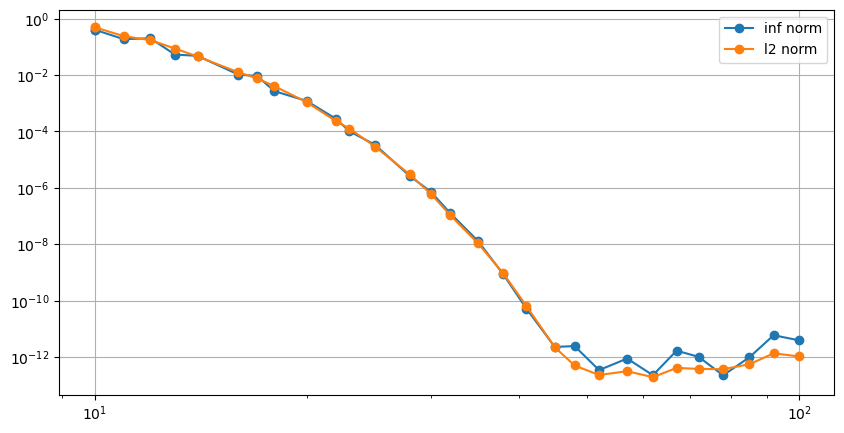

In [286]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.loglog(N_grid, error_dv_array, marker = "o", label = "inf norm")
ax.loglog(N_grid, error_l2_norm, marker = "o", label = "l2 norm")
ax.legend()
ax.grid();

## 2l) Mass matrix

In [324]:
def u1(x): return 1
def u2(x): return np.sin(x)

a, b = 0, 2

l2_norm_1 = np.sqrt(quad(lambda x: u1(x)**2, a, b)[0])
l2_norm_2 = np.sqrt(quad(lambda x: u2(x)**2, a, b)[0])
print(f"{l2_norm_1 = }, {l2_norm_2 = }")

# t in [-1, 1], x in [a, b]
def any2reference(x, a, b): return (2*x - (a+b)) / (b-a)
def reference2any(t, a, b): return ((b-a)*t + (a+b)) / 2
def any2reference_derivative(a, b): return 2 / (b-a)

x_plot = np.linspace(a, b, 500)

N = 10
x = JacobiGL(alpha, beta, N)
V = constructV(x, alpha=alpha, beta=beta)
M = linalg.inv(V @ V.T)
print(f"{np.linalg.cond(M, 2) = }")

l2_norm_1 = np.float64(1.4142135623730951), l2_norm_2 = np.float64(1.0905047564439974)
np.linalg.cond(M, 2) = np.float64(31.871395299515775)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/4003414682.py:20: RuntimeWarning: divide by zero encountered in matmul
  M = linalg.inv(V @ V.T)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/4003414682.py:20: RuntimeWarning: overflow encountered in matmul
  M = linalg.inv(V @ V.T)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/4003414682.py:20: RuntimeWarning: invalid value encountered in matmul
  M = linalg.inv(V @ V.T)


In [328]:
def constructM(x, alpha, beta, a, b):
    V = constructV(x, alpha=alpha, beta=beta)
    M = linalg.inv(V @ V.T)
    M = ((b-a) / 2) * M  # account for change of interval
    return M

In [337]:
N = 20
x = JacobiGL(alpha, beta, N)
M = constructM(x, alpha, beta, a, b)

l2_norm_2_approx = np.sqrt(u2(x) @ M @ u2(x))

print()
print(f"{l2_norm_2 = }, {l2_norm_2_approx = }")


l2_norm_2 = np.float64(1.0905047564439974), l2_norm_2_approx = np.float64(0.9057035949822478)


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/891186150.py:3: RuntimeWarning: divide by zero encountered in matmul
  M = linalg.inv(V @ V.T)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/891186150.py:3: RuntimeWarning: overflow encountered in matmul
  M = linalg.inv(V @ V.T)
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_36591/891186150.py:3: RuntimeWarning: invalid value encountered in matmul
  M = linalg.inv(V @ V.T)
